In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

import scipy.stats as stats

import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
from pingouin import pairwise_ttests
from sklearn.linear_model import LinearRegression

In [78]:
dir_plots = './plots'

In [2]:
df = pd.read_csv('merged_data.csv')
df.head()

,mergeid,female,age,bmi,activity,ENMO_hour,GGIR_N_valid_hours,hour,measurementday,weekday,...,country,disease,d1,d2,d3,d4,d5,d6,d7,control
0,Bf-031257-01,0,67.0,21.155294,9.0,6.697222,0.0,12am-1am,1,Tuesday,...,Belgium,control,0,0,0,0,0,0,0,1
1,Bf-031257-01,0,67.0,21.155294,9.0,10.741667,0.0,1am-2am,1,Tuesday,...,Belgium,control,0,0,0,0,0,0,0,1
2,Bf-031257-01,0,67.0,21.155294,9.0,7.848472,0.5,2am-3am,1,Tuesday,...,Belgium,control,0,0,0,0,0,0,0,1
3,Bf-031257-01,0,67.0,21.155294,9.0,0.244306,1.0,3am-4am,1,Tuesday,...,Belgium,control,0,0,0,0,0,0,0,1
4,Bf-031257-01,0,67.0,21.155294,9.0,4.214167,1.0,4am-5am,1,Tuesday,...,Belgium,control,0,0,0,0,0,0,0,1


In [3]:
def calc_ENMO_stats(df, enmo_col='ENMO_hour'):
    df = df.copy()
    mean = df.groupby('mergeid')[enmo_col].mean()
    median = df.groupby('mergeid')[enmo_col].median()
    var = df.groupby('mergeid')[enmo_col].var()
    mean.name = 'mean_ENMO'
    median.name = 'median_ENMO'
    var.name = 'var_ENMO'
    df = pd.merge(left=df, left_on='mergeid', right=mean, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=median, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=var, right_on='mergeid', how='left')
    return df

df_stat= calc_ENMO_stats(df)   
df_stat = df_stat.drop_duplicates(subset='mergeid', keep='first')
cols = ['ENMO_hour','GGIR_N_valid_hours','measurementday', 'hour', 'weekday']
df_stat.drop(cols, inplace=True, axis=1)
df_stat.head(5)

,mergeid,female,age,bmi,activity,month,year,device_id,frequency,position,...,d2,d3,d4,d5,d6,d7,control,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,0,67.000000,21.155294,9.0,February,2020,68652.0,50,Left,...,0,0,0,0,0,0,1,12.164127,9.664236,119.962879
168,Bf-043946-02,1,57.299999,38.446751,2.0,February,2020,30920.0,50,Left,...,0,0,0,0,0,0,0,13.780020,8.492361,209.996045
336,Bf-073169-01,0,72.500000,25.209202,9.0,March,2020,68652.0,50,Right,...,0,0,0,0,0,0,0,16.090929,11.452292,537.459251
504,Bf-227520-04,0,56.099998,24.593210,2.0,March,2020,17212.0,50,Right,...,0,0,0,0,0,0,0,11.543128,11.326111,74.794850
552,Bf-286437-02,1,68.099998,30.778702,1.0,February,2020,54007.0,50,Right,...,0,0,0,0,0,0,0,38.811152,48.127569,367.199181


C:\Users\mjbur\AppData\Local\Temp\ipykernel_160\3626546447.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlabels)


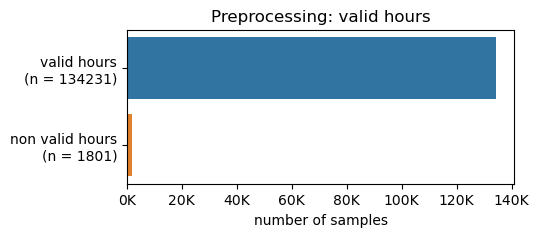

In [4]:
valid_hour_threshold = 0.0

fig = plt.figure(figsize=[5,2])
_valid_hours = len(df[df['GGIR_N_valid_hours']>valid_hour_threshold])
_non_valid_hours = len(df[df['GGIR_N_valid_hours']<=valid_hour_threshold])

data = pd.DataFrame({
    f'valid hours\n(n = {_valid_hours})': [_valid_hours],
    f'non valid hours\n(n = {_non_valid_hours})': [_non_valid_hours],
})

p = sns.barplot(data=data, orient='horizontal')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlabels)
#plt.xticks(rotation=-20)
plt.xlabel("number of samples")

plt.title(f"Preprocessing: valid hours")
plt.show()

In [14]:
mean_day = df.groupby(["mergeid", "measurementday"], as_index=False).ENMO_hour.mean()
disease = df_stat[["mergeid", "disease", 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].copy()
df_b = pd.merge(mean_day, disease)
df_b 

,mergeid,measurementday,ENMO_hour,disease,d1,d2,d3,d4,d5,d6,d7,control
0,Bf-031257-01,1,7.842784,control,0,0,0,0,0,0,0,1
1,Bf-031257-01,2,13.951765,control,0,0,0,0,0,0,0,1
2,Bf-031257-01,3,14.691516,control,0,0,0,0,0,0,0,1
3,Bf-031257-01,4,11.845631,control,0,0,0,0,0,0,0,1
4,Bf-031257-01,5,15.103767,control,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5663,SI-992596-02,3,15.108547,d2,0,1,0,0,0,0,0,0
5664,SI-992596-02,4,13.619786,d2,0,1,0,0,0,0,0,0
5665,SI-992596-02,5,15.352413,d2,0,1,0,0,0,0,0,0
5666,SI-992596-02,6,16.026400,d2,0,1,0,0,0,0,0,0


In [16]:
maov = MANOVA.from_formula('measurementday + ENMO_hour ~ d1+d2+d3+d4+d5+d6+d7', data=df_b)
print(maov.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.2801 2.0000 5659.0000 7273.0886 0.0000
         Pillai's trace 0.7199 2.0000 5659.0000 7273.0886 0.0000
 Hotelling-Lawley trace 2.5705 2.0000 5659.0000 7273.0886 0.0000
    Roy's greatest root 2.5705 2.0000 5659.0000 7273.0886 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
             d1           Value  Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------
            Wilks' lambda 0.9991 2.0000 5659.0000  2.6795 0.0687
           Pillai's trace 0.0009 2.0000 5659.

In [18]:
LPA_t = 25.0
MVPA_t = 75.0

df_b['behaviour'] = np.where((df_b['ENMO_hour'] > MVPA_t), str("MVPA"), str("LPA"))
df_b['behaviour'] = df_b['behaviour'].mask(df_b['ENMO_hour'] <= LPA_t, str("SED"))

df_b.head()

,mergeid,measurementday,ENMO_hour,disease,d1,d2,d3,d4,d5,d6,d7,control,behaviour
0,Bf-031257-01,1,7.842784,control,0,0,0,0,0,0,0,1,SED
1,Bf-031257-01,2,13.951765,control,0,0,0,0,0,0,0,1,SED
2,Bf-031257-01,3,14.691516,control,0,0,0,0,0,0,0,1,SED
3,Bf-031257-01,4,11.845631,control,0,0,0,0,0,0,0,1,SED
4,Bf-031257-01,5,15.103767,control,0,0,0,0,0,0,0,1,SED


In [19]:
maov = MANOVA.from_formula('measurementday + behaviour ~ d1+d2+d3+d4+d5+d6+d7', data=df_b)
print(maov.mv_test())

                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept               Value         Num DF   Den DF          F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda               0.0000 4.0000 5657.0000 670443765579864192.0000 0.0000
         Pillai's trace               1.0000 4.0000 5657.0000 670443765579864320.0000 0.0000
 Hotelling-Lawley trace 474063118670577.5000 4.0000 5657.0000 670443765579864320.0000 0.0000
    Roy's greatest root 474063118670577.5000 4.0000 5657.0000 670443765579864192.0000 0.0000
--------------------------------------------------------------------------------------------
                                                                                            
-----------

C:\Users\mjbur\AppData\Local\Temp\ipykernel_22088\1769299180.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlabels)


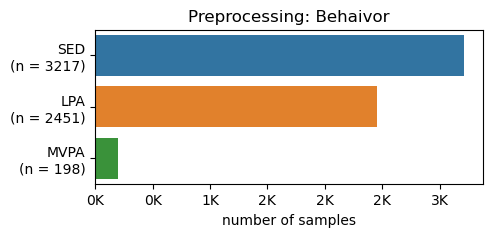

In [97]:
LPA_t = 25.0
MVPA_t = 75.0

fig = plt.figure(figsize=[5,2])

_SED = len(mean_day[mean_day['ENMO_hour'] <= LPA_t])
_LPA = len(mean_day[mean_day['ENMO_hour'] > LPA_t])
_MVPA = len(mean_day[mean_day['ENMO_hour'] > MVPA_t])

data = pd.DataFrame({
    f'SED\n(n = {_SED})': [_SED],
    f'LPA\n(n = {_LPA})': [_LPA],
    f'MVPA\n(n = {_MVPA})': [_MVPA],
})

p = sns.barplot(data=data, orient='horizontal')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlabels)
#plt.xticks(rotation=-20)
plt.xlabel("number of samples")

plt.title(f"Preprocessing: Behaivor")
plt.show()

Characteristics of the participants

total number of respondents

In [23]:
total_participants = df_stat[df_stat.columns[0]].count()
total_participants

856

Counting responents in each group

In [24]:
df_stat['disease']  = df_stat[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)
df_stat['disease'].value_counts()

control    383
d1         241
d4          68
d3          48
d5          46
d2          44
d7          20
d6           6
Name: disease, dtype: int64

<AxesSubplot:xlabel='disease'>

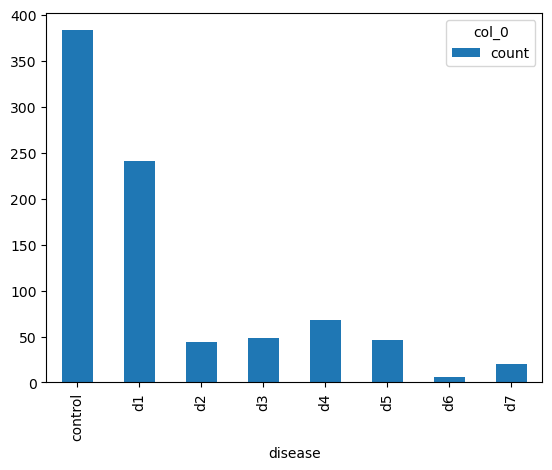

In [25]:
disease_table = pd.crosstab(index=df_stat['disease'], columns='count')
disease_table.plot(kind='bar')

Age mean and standard devation

In [26]:
st_dev_age = df_stat.groupby('disease')['age'].agg(['mean', 'std']) # for mean and std deviation
st_dev_age

,mean,std
disease,,
control,66.881985,8.529482
d1,70.952283,9.454537
d2,70.270455,8.690374
d3,70.043751,9.603056
d4,71.286765,7.044717
d5,70.734783,8.596956
d6,72.516667,7.085878
d7,71.655000,8.660587


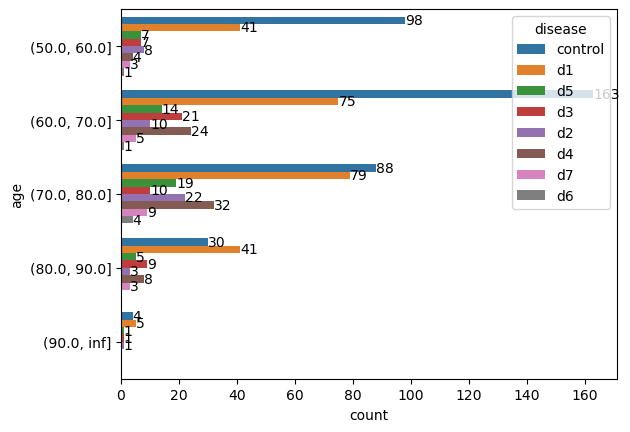

In [69]:
data = pd.DataFrame({
    "age": pd.cut(df_stat["age"], bins=[50, 60, 70, 80, 90, np.inf]),
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="age", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("age")
plt.show()

BMI mean and standard devation

In [70]:
st_dev_BMI = df_stat.groupby('disease')['bmi'].agg(['mean', 'std']) # for mean and std deviation
st_dev_BMI

,mean,std
disease,,
control,25.851241,4.853359
d1,28.207152,5.659255
d2,28.617814,4.356346
d3,26.259079,5.669901
d4,28.386495,8.002335
d5,29.501451,6.631926
d6,26.817510,3.482822
d7,28.093996,12.739242


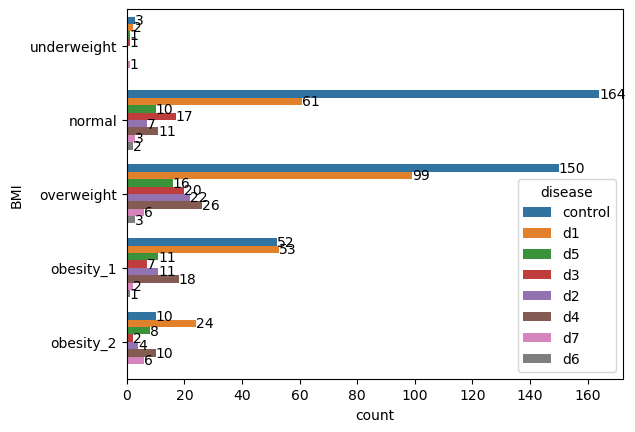

In [71]:
data = pd.DataFrame({
    "BMI": pd.cut(df_stat["bmi"], bins=[0, 18.5, 25, 30, 35, np.inf],
                            labels=["underweight", "normal", "overweight", "obesity_1", "obesity_2"]),
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="BMI", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

Number of participants depending on gender

In [72]:
count_sex = df_stat.groupby('disease')['female'].value_counts()
count_sex

disease  female
control  1         220
         0         163
d1       1         135
         0         106
d2       1          24
         0          20
d3       1          36
         0          12
d4       0          37
         1          31
d5       1          36
         0          10
d6       1           4
         0           2
d7       1          13
         0           7
Name: female, dtype: int64

in %:

In [73]:
for x in count_sex:
    print(x, '\t %.2f' % (x/total_participants*100))

220 	 25.70
163 	 19.04
135 	 15.77
106 	 12.38
24 	 2.80
20 	 2.34
36 	 4.21
12 	 1.40
37 	 4.32
31 	 3.62
36 	 4.21
10 	 1.17
4 	 0.47
2 	 0.23
13 	 1.52
7 	 0.82


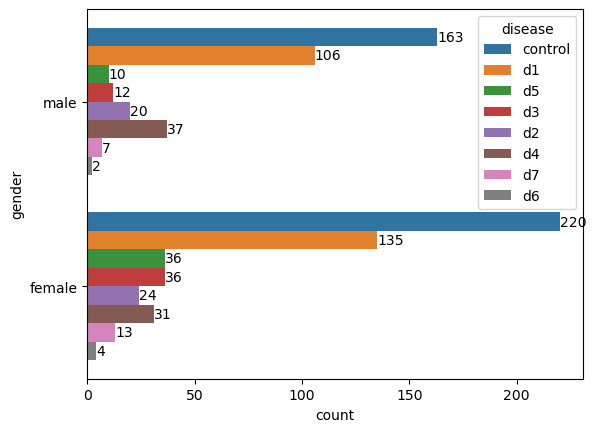

In [74]:
data = pd.DataFrame({
    "gender": df_stat["female"],
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="gender", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_yticklabels(["male", "female"])
plt.show()

<AxesSubplot:title={'center':'median_ENMO'}, xlabel='disease'>

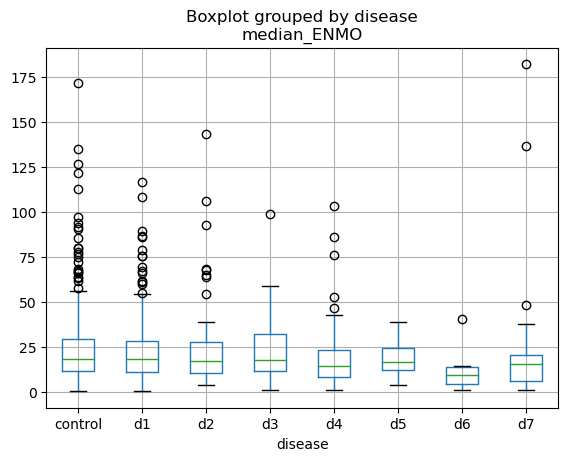

In [65]:
df_stat.boxplot(column='median_ENMO', by='disease')

<AxesSubplot:title={'center':'activity'}, xlabel='disease'>

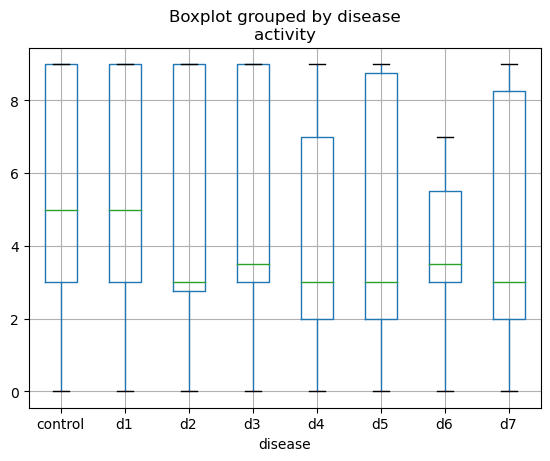

In [66]:
df_stat.boxplot(column='activity', by='disease')

In [67]:
from matplotlib import cm
def qqplot(x, y,palette= cm.viridis, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, edgecolor="none", palette=palette, *args, **kwargs)

<Figure size 1000x1000 with 0 Axes>

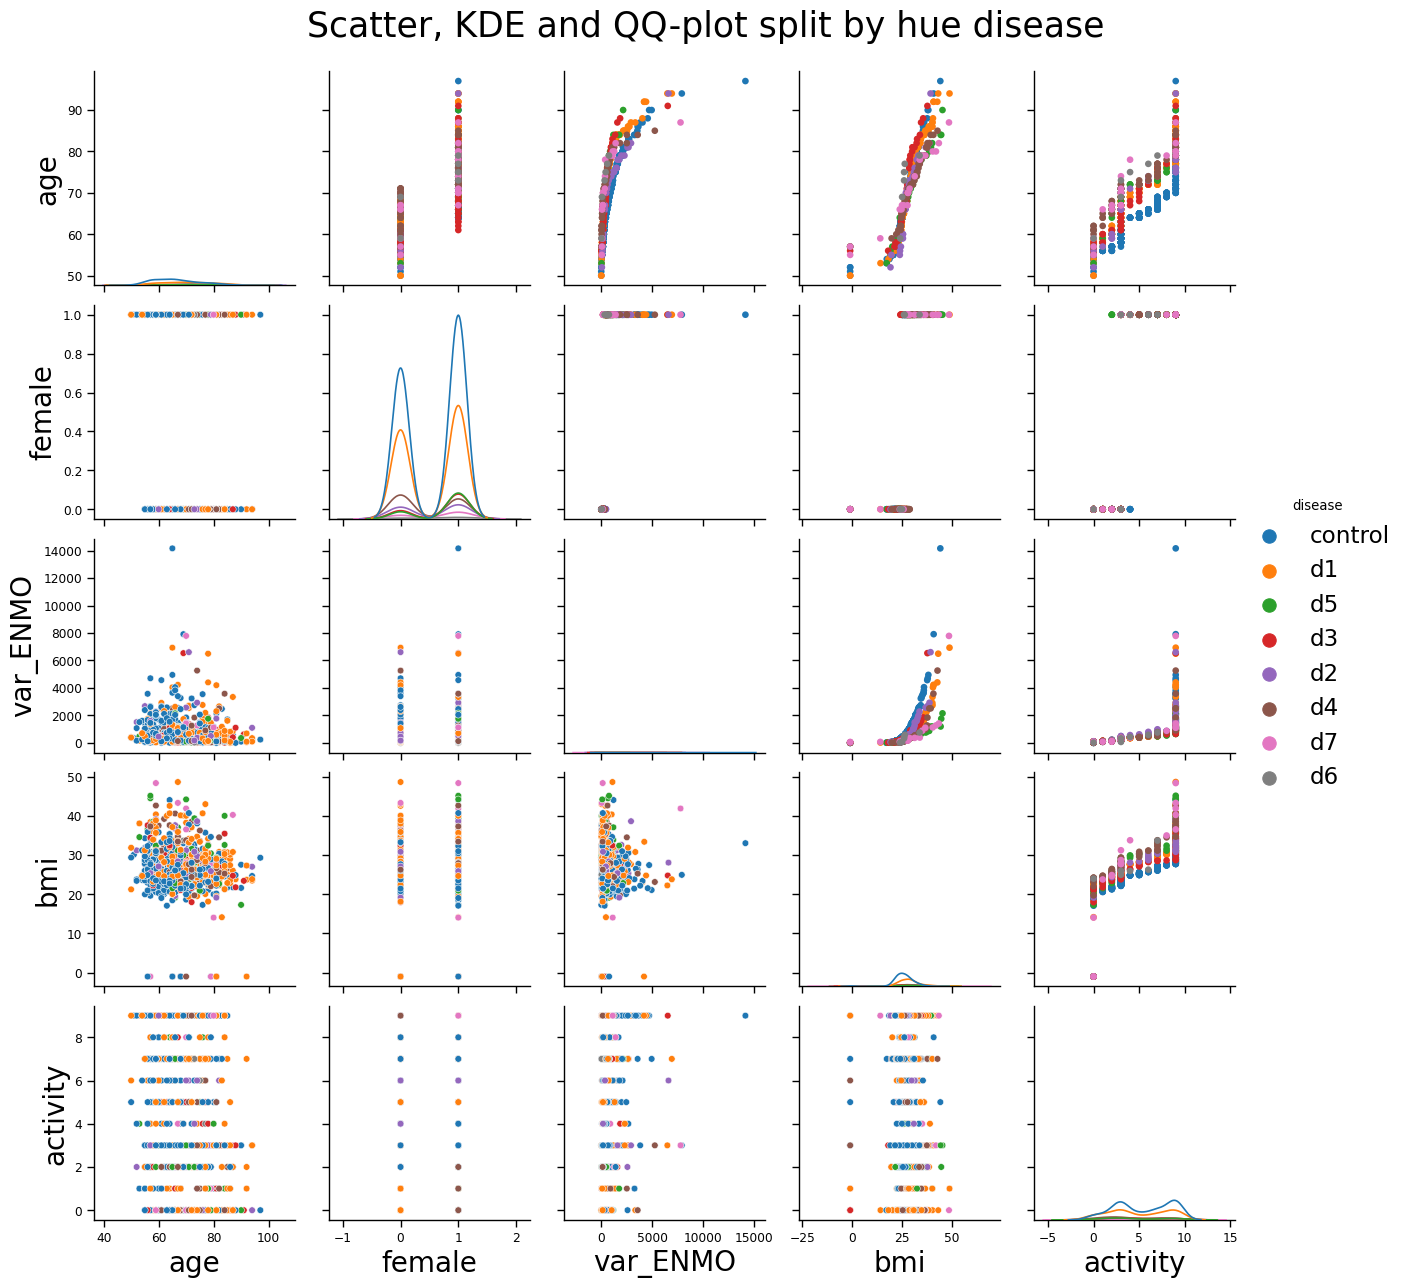

In [71]:
var= [
    'age', 'female', 
    'var_ENMO', #enmo
    'bmi', #behaviour risks
    'activity', #self-reported score
]
hue = 'disease'

sns.set_context("paper", rc={"axes.labelsize":20})

plt.figure(figsize=[10,10])
g = sns.PairGrid(data=df_stat, vars=var, hue=hue, dropna=True)
    #with sns.color_palette('viridis', n_colors=len(df_anno[hue].unique())):
g.map_upper(qqplot)
g.map_diag(sns.kdeplot, warn_singular=False)
g.map_lower(sns.scatterplot)

g.fig.suptitle(f'Scatter, KDE and QQ-plot split by hue {hue}', y=1.03, size=25)
g.add_legend(title = hue, title_fontsize='xx-large', fontsize='xx-large', markerscale=2)
#plt.savefig(os.path.join(plot_dir, f'scatter_kde_qq_{hue}.png'))
plt.show()

In [75]:
model = ols('var_ENMO ~ disease', data=df_stat).fit()

anova_result = sm.stats.anova_lm(model,typ=2)
print(anova_result)

                sum_sq     df         F    PR(>F)
disease   1.116179e+07    7.0  1.475515  0.172389
Residual  9.164062e+08  848.0       NaN       NaN


In [9]:
posthoc = pairwise_ttests(dv='var_ENMO', between='disease', padjust='bonf', data=df_stat, correction=False)
posthoc

c:\Users\mjbur\anaconda3\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,disease,control,d1,False,True,1.435986,622.0,two-sided,0.151509,1.000000,bonf,0.25,0.117926
1,disease,control,d2,False,True,-0.591711,425.0,two-sided,0.554359,1.000000,bonf,0.202,-0.094022
2,disease,control,d3,False,True,1.140211,429.0,two-sided,0.254835,1.000000,bonf,0.302,0.174278
3,disease,control,d4,False,True,1.819335,449.0,two-sided,0.069526,1.000000,bonf,0.683,0.239013
4,disease,control,d5,False,True,1.973522,427.0,two-sided,0.049080,1.000000,bonf,1.016,0.307417
5,disease,control,d6,False,True,0.984560,387.0,two-sided,0.325455,1.000000,bonf,0.53,0.404295
6,disease,control,d7,False,True,0.052263,401.0,two-sided,0.958345,1.000000,bonf,0.238,0.011965
7,disease,d1,d2,False,True,-1.439710,283.0,two-sided,0.151055,1.000000,bonf,0.456,-0.235401
8,disease,d1,d3,False,True,0.456717,287.0,two-sided,0.648220,1.000000,bonf,0.188,0.072000
9,disease,d1,d4,False,True,1.066286,307.0,two-sided,0.287132,1.000000,bonf,0.255,0.146059


In [37]:
model = ols('median_ENMO ~ disease', data=df_stat).fit()

anova_result = sm.stats.anova_lm(model,typ=2)
print(anova_result)

                 sum_sq     df         F    PR(>F)
disease     4572.766393    7.0  1.473997  0.172943
Residual  375820.265605  848.0       NaN       NaN


In [38]:
model = ols('mean_ENMO ~ disease', data=df_stat).fit()

anova_result = sm.stats.anova_lm(model,typ=2)
print(anova_result)

                 sum_sq     df         F    PR(>F)
disease     4232.068281    7.0  1.528956  0.153818
Residual  335316.848012  848.0       NaN       NaN


In [12]:
model = ols('activity ~ disease', data=df_stat).fit()

anova_result = sm.stats.anova_lm(model,typ=2)
print(anova_result)

               sum_sq     df         F    PR(>F)
disease    154.068468    7.0  2.269212  0.027166
Residual  8225.010971  848.0       NaN       NaN


In [10]:
#supposing equal variance
posthoc = pairwise_ttests(dv='activity', between='disease', padjust='bonf', data=df_stat, correction=False)
posthoc

c:\Users\mjbur\anaconda3\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,disease,control,d1,False,True,1.901396,622.0,two-sided,0.057712,1.000000,bonf,0.532,0.156147
1,disease,control,d2,False,True,1.411194,425.0,two-sided,0.158919,1.000000,bonf,0.429,0.224237
2,disease,control,d3,False,True,1.645595,429.0,two-sided,0.100580,1.000000,bonf,0.579,0.251525
3,disease,control,d4,False,True,3.160533,449.0,two-sided,0.001681,0.047077,bonf,15.566,0.415211
4,disease,control,d5,False,True,1.548326,427.0,two-sided,0.122285,1.000000,bonf,0.509,0.241184
5,disease,control,d6,False,True,1.306022,387.0,two-sided,0.192321,1.000000,bonf,0.691,0.536299
6,disease,control,d7,False,True,1.871148,401.0,two-sided,0.062053,1.000000,bonf,1.077,0.428383
7,disease,d1,d2,False,True,0.379258,283.0,two-sided,0.704781,1.000000,bonf,0.188,0.062011
8,disease,d1,d3,False,True,0.560589,287.0,two-sided,0.575515,1.000000,bonf,0.197,0.088374
9,disease,d1,d4,False,True,1.785547,307.0,two-sided,0.075160,1.000000,bonf,0.666,0.244582


In [9]:
x = df_stat["var_ENMO"].to_numpy().reshape((-1,1))
y = df_stat["activity"].to_numpy()
model = LinearRegression()
model.fit(x,y)
r_seq = model.score(x,y)
print(r_seq)

0.02438929214744534


Long to wide format

In [11]:
df.loc[:, 'measurementday'] = df.replace({1: 'day1', 2: 'day2', 3: 'day3', 4: 'day4', 5: 'day5', 6: 'day6', 7: 'day7'})
df_wide = df.pivot_table(index='mergeid', columns='measurementday', values='ENMO_hour', aggfunc={'ENMO_hour': np.mean})
df_wide.dropna(inplace=True)
df_wide = pd.merge(df_wide, df_stat, on='mergeid')
df_wide.head(5)

# alternative: https://www.statology.org/pandas-pivot-table-column-names/

,mergeid,day1,day2,day3,day4,day5,day6,day7,female,age,...,d2,d3,d4,d5,d6,d7,control,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,7.842784,13.951765,14.691516,11.845631,15.103767,8.624473,13.088953,0,67.000000,...,0,0,0,0,0,0,1,12.164127,9.664236,119.962879
1,Bf-043946-02,14.734543,12.709763,11.554774,15.158368,8.666696,16.909890,16.726105,1,57.299999,...,0,0,0,0,0,0,0,13.780020,8.492361,209.996045
2,Bf-073169-01,25.244525,10.036458,12.613015,11.006794,21.812749,15.087454,16.835509,0,72.500000,...,0,0,0,0,0,0,0,16.090929,11.452292,537.459251
3,Bf-291361-02,42.403131,53.354855,53.780660,45.536817,44.093501,42.671858,40.565764,1,71.199997,...,0,0,0,0,0,0,1,46.058084,43.160000,1278.062974
4,Bf-294636-01,19.117378,15.019144,14.817222,15.841696,16.929803,16.612344,19.187679,1,55.900002,...,0,0,0,0,0,0,1,16.789324,15.660556,55.480780


In [56]:
maov = MANOVA.from_formula('day1 + day2 + day3 + day4 + day5 + day6 + day7 ~ d1 + d2 + d3 + d4 + d5 + d6 + d7', data=df_wide)
print(maov.mv_test())

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.5090 7.0000 706.0000 97.2797 0.0000
         Pillai's trace 0.4910 7.0000 706.0000 97.2797 0.0000
 Hotelling-Lawley trace 0.9645 7.0000 706.0000 97.2797 0.0000
    Roy's greatest root 0.9645 7.0000 706.0000 97.2797 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
           d1           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9892 7.0000 706.0000  1.1053 0.3577
         Pillai's trace 0.0108 7.0000 706.0000  1.1053 0.3577
 Hotelling-Lawley trace 0.

In [ ]:
maov = MANOVA.from_formula('day1 + day2 + day3 + day4 + day5 + day6 + day7 ~ d1 + d2 + d3 + d4 + d5 + d6 + d7', data=df_wide)
print(maov.mv_test())

In [ ]:
'''
from sklearn.decomposition import PCA
from sklearn import preprocessing


data = pd.crosstab(index=df['mergeid'], columns=df['disease'], values=df['ENMO_hour'], aggfunc={'ENMO_hour': np.var})
scaled_data = preprocessing.scale(data)

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principle Component')
plt.title('Scree Plot')
plt.show()
'''

In [ ]:
'''
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
# to test significance of the group differences 
X = df_stat[["d5", "control"]]
y = df_stat["ENMO_hour"]
y = y.astype(int)
post_hoc = lda().fit(X=X, y=y)

# plot 
X_new = pd.DataFrame(lda().fit(X=X, y=y).transform(X), columns=["lda1", "lda2"])
X_new["ENMO_hour"] = df_stat["ENMO_hour"]
sns.scatterplot(data=X_new, x="lda1", y="lda2", hue=df_stat.ENMO_hour.tolist())
plt.show()
'''

In [ ]:
'''
reg = ols('d1~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)
'''